# Mushrooms Dataset Classification

This is a project to explore the [Mushrooms dataset from Kaggle](https://www.kaggle.com/datasets/uciml/mushroom-classification).


In [35]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import statsmodels
import sweetviz as sv
import graphviz 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

We will start by defining some functions which will come in handy later.

In [2]:
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    """Function to fit model to training data and generate predictions. 
    Another function, performance_metrics_recorder, is called to record the results
    of the predictions to a dataframe for later analysis.

    Args:
        model (instance): An instance of a classifier model.
        X_train (pd.DataFrame): Dataframe containing training data for all columns except target.
        X_test (pd.DataFrame): Dataframe containing testing data for all columns except target.
        y_train (pd.DataFrame): Dataframe containing training data for target column.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.

    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)

    return (model, df, model_confusion)

def performance_metrics_recorder(predictions, y_test, df, model_name):
    """Helper function to record scores for model predictions in a DataFrame.

    Args:
        predictions (pd.DataFrame): Dataframe of predictions generated by classifier.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.
    
    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name,model_accuracy_score,model_precision_score,model_recall_score,model_f1_score]

    return(df, model_confusion)

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    """Helper function to visualize feature importance.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    features_list = X.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    """Helper function to visualize feature importance for algorithms that do 
    not support the model.feature_importances_ method.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(), 
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

## Step One: Data Exploration, Analysis and Pre-Processing

In this section, we explore the raw dataset and clean it for later use.

In [3]:
# reading the raw CSV data file
df = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# finding columns in the df which have any null/na values
np.where(pd.isna(df))

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# Checking the missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

We find that this is a rare perfect dataset with no NA or null values.

In [6]:
df.shape

(8124, 23)

We also note that there are 23 columns (i.e. features), and 8124 rows of data.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [8]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


We noted the column names, their data types, and the number of unique values for each feature. We see that they are all object data types, i.e. strings, and have several distinct values. We will need to convert these strings to a numerical data type. Let's perform label encoding on these features for simplicity.

In [10]:
# creating a copy of the original dataframe
df2 = df.copy()

In [11]:
# performing Label Encoding on each of the 23 features
for col in df2.columns:
    le = LabelEncoder()
    le.fit(df2[col])
    df2[col] = le.transform(df2[col])
    if col == 'class':
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

{'e': 0, 'p': 1}


So we learn that the LabelEncoding method has encoded class 'edible' to 0, and 'poisonous' to 1. Good to know for future reference!

In [44]:
counts = df2['class'].value_counts()
print(counts)

0    4208
1    3916
Name: class, dtype: int64


In [45]:
total_counts = 4208 + 3916
print((4208/total_counts)*100)
print((3916/total_counts)*100)

51.7971442639094
48.20285573609059


The data seems balanced - there is very roughly a 50-50 ratio for both edible and poisonous mushrooms, which indicates our data is balanced. Therefore, we won't apply balancing methods like SMOTE here.

In [12]:
# examining the label-encoded dataframe
df2.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Now that the dataframe is in a numerical format, we can perform some more Exploratory Data Analysis (EDA). Let's start by visualizing the correlation of the features to each other.

In [13]:
# getting correlation matrix of matrix
corr = df2.corr()
corr.style.background_gradient('coolwarm')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [14]:
df2['veil-type'].unique()

array([0])

It seems that the 'nan' in the correlation matrix for the veil-type column is because the label for that column has been encoded as 0. Looking back at the original data, it seems that there is only one value for veil-type, 'p', which has been encoded to 0. This may or may not be a problem later, only time will tell.

In [15]:
df3 = df2.copy()
scaler = StandardScaler()
# scaler.fit(df3)
df3 = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [16]:
# getting correlation matrix of matrix
corr = df3.corr()
corr.style.background_gradient('coolwarm')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


## Step Two: Classification Models

We start by splitting the dataset into two distinct sets, X - which contains all the features except for the target feature ('class'), and Y - which only contains the target feature ('class'), and creating train/test splits by an 80/20% split ratio.

In [17]:
# splitting dataset
X = df2.drop(['class'],axis=1)
Y = df2['class']

In [18]:
# creating train/test split using 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [19]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1"]
performance_metrics = pd.DataFrame(columns=column_names)

Now we will use some models and classify the data.

In [20]:
# Naive Bayes
nb = GaussianNB()
nb, performance_metrics, nb_confusion = model_predictions(nb, X_train, X_test, y_train, y_test, performance_metrics, "Naive Bayes")

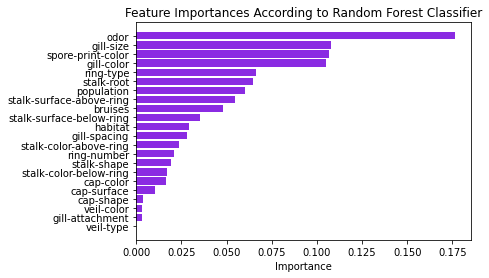

In [21]:
# Random Forest
label = "Random Forest"
rf = RandomForestClassifier(random_state=42)
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")

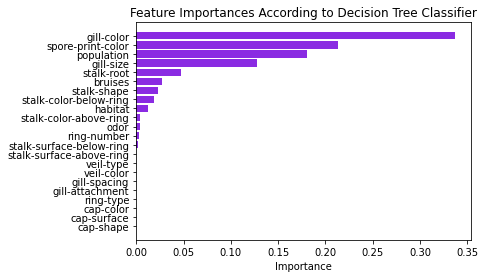

In [22]:
# Decision Tree
label = "Decision Tree"
dt = tree.DecisionTreeClassifier()
dt, performance_metrics, dt_confusion = model_predictions(dt, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, dt, label, color="blueviolet")

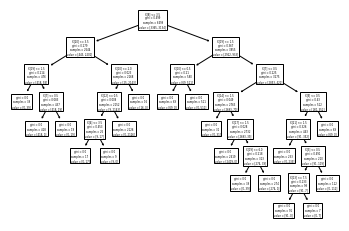

In [23]:
tree.plot_tree(dt);

In [38]:
# dot_data = export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=['edible', 'poisonous'])
# graph = graphviz.Source(dot_data)
# graph

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


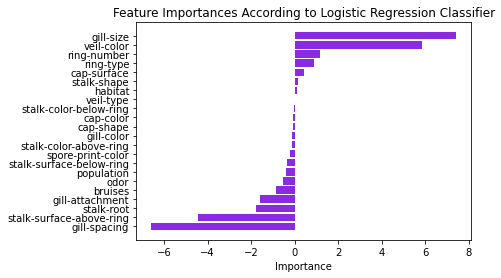

In [32]:
# Logistic Regression
label = "Logistic Regression"
lr = LogisticRegression()
lr, performance_metrics, lr_confusion = model_predictions(lr, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, lr, label, color="blueviolet");

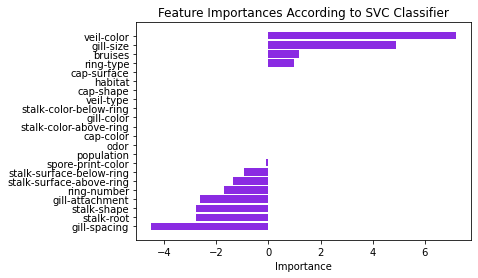

In [25]:
# Decision Tree
label = "SVC"
svc = SVC(kernel='linear')
svc, performance_metrics, svc_confusion = model_predictions(svc, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, svc, label, color="blueviolet")

In [26]:
# Decision Tree
label = "KNN"
knn = KNeighborsClassifier()
knn, performance_metrics, knn_confusion = model_predictions(knn, X_train, X_test, y_train, y_test, performance_metrics, label)

In [27]:
performance_metrics

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,Decision Tree,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153
4,SVC,0.972923,0.981723,0.961637,0.971576
5,KNN,0.996308,0.992386,1.000000,0.996178


/var/folders/mm/6lyr9rbs7vd53tnvwt0676zm0000gn/T/ipykernel_19803/1630083778.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


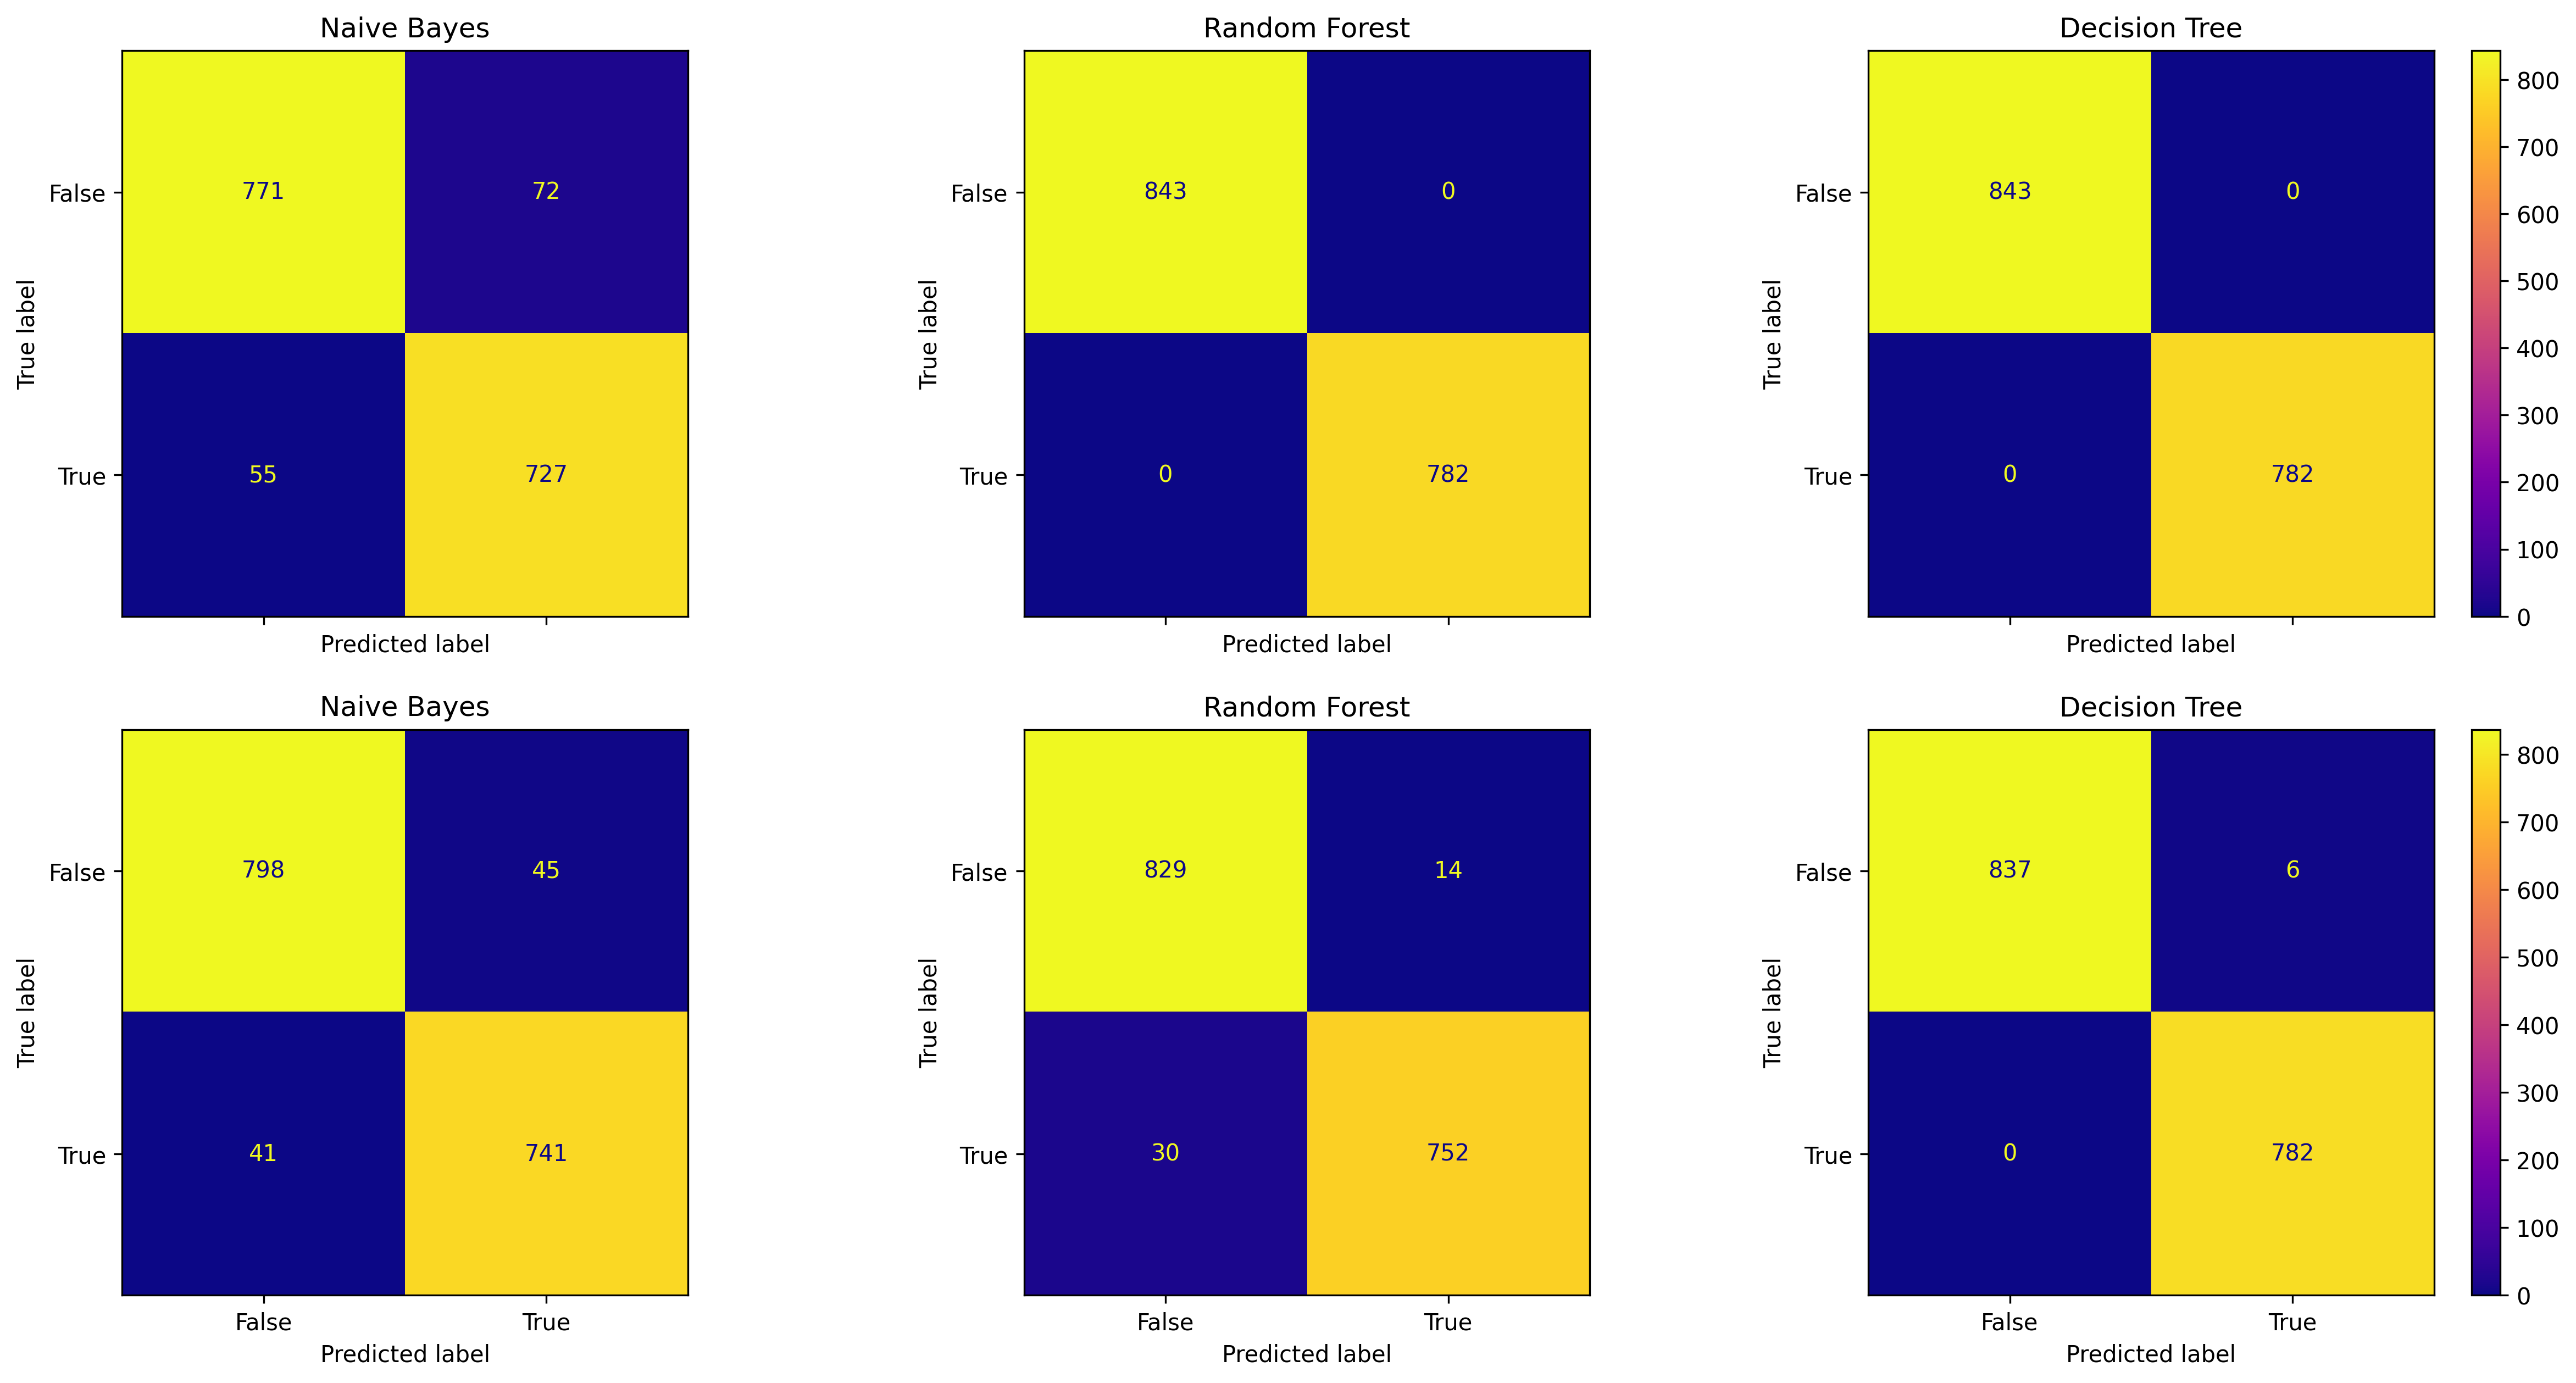

In [31]:
# comparing confusion matrices for this stage of analysis
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))

fig, ax = plt.subplots(2,3,sharex=True, sharey=False, figsize=(20, 10), dpi=300)

# first row
ax[0, 0].set_title(x_labels[0])
ax[0, 1].set_title(x_labels[1])
ax[0, 2].set_title(x_labels[2])
# second row
ax[1, 0].set_title(x_labels[0])
ax[1, 1].set_title(x_labels[1])
ax[1, 2].set_title(x_labels[2])

# first row
ConfusionMatrixDisplay(nb_confusion,display_lasbels=[False,True]).plot(ax=ax[0, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_confusion,display_labels=[False,True]).plot(ax=ax[0, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(dt_confusion,display_labels=[False,True]).plot(ax=ax[0, 2],cmap='plasma',colorbar=True)
# second row
ConfusionMatrixDisplay(lr_confusion,display_labels=[False,True]).plot(ax=ax[1, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(svc_confusion,display_labels=[False,True]).plot(ax=ax[1, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(knn_confusion,display_labels=[False,True]).plot(ax=ax[1, 2],cmap='plasma',colorbar=True)
fig.show()

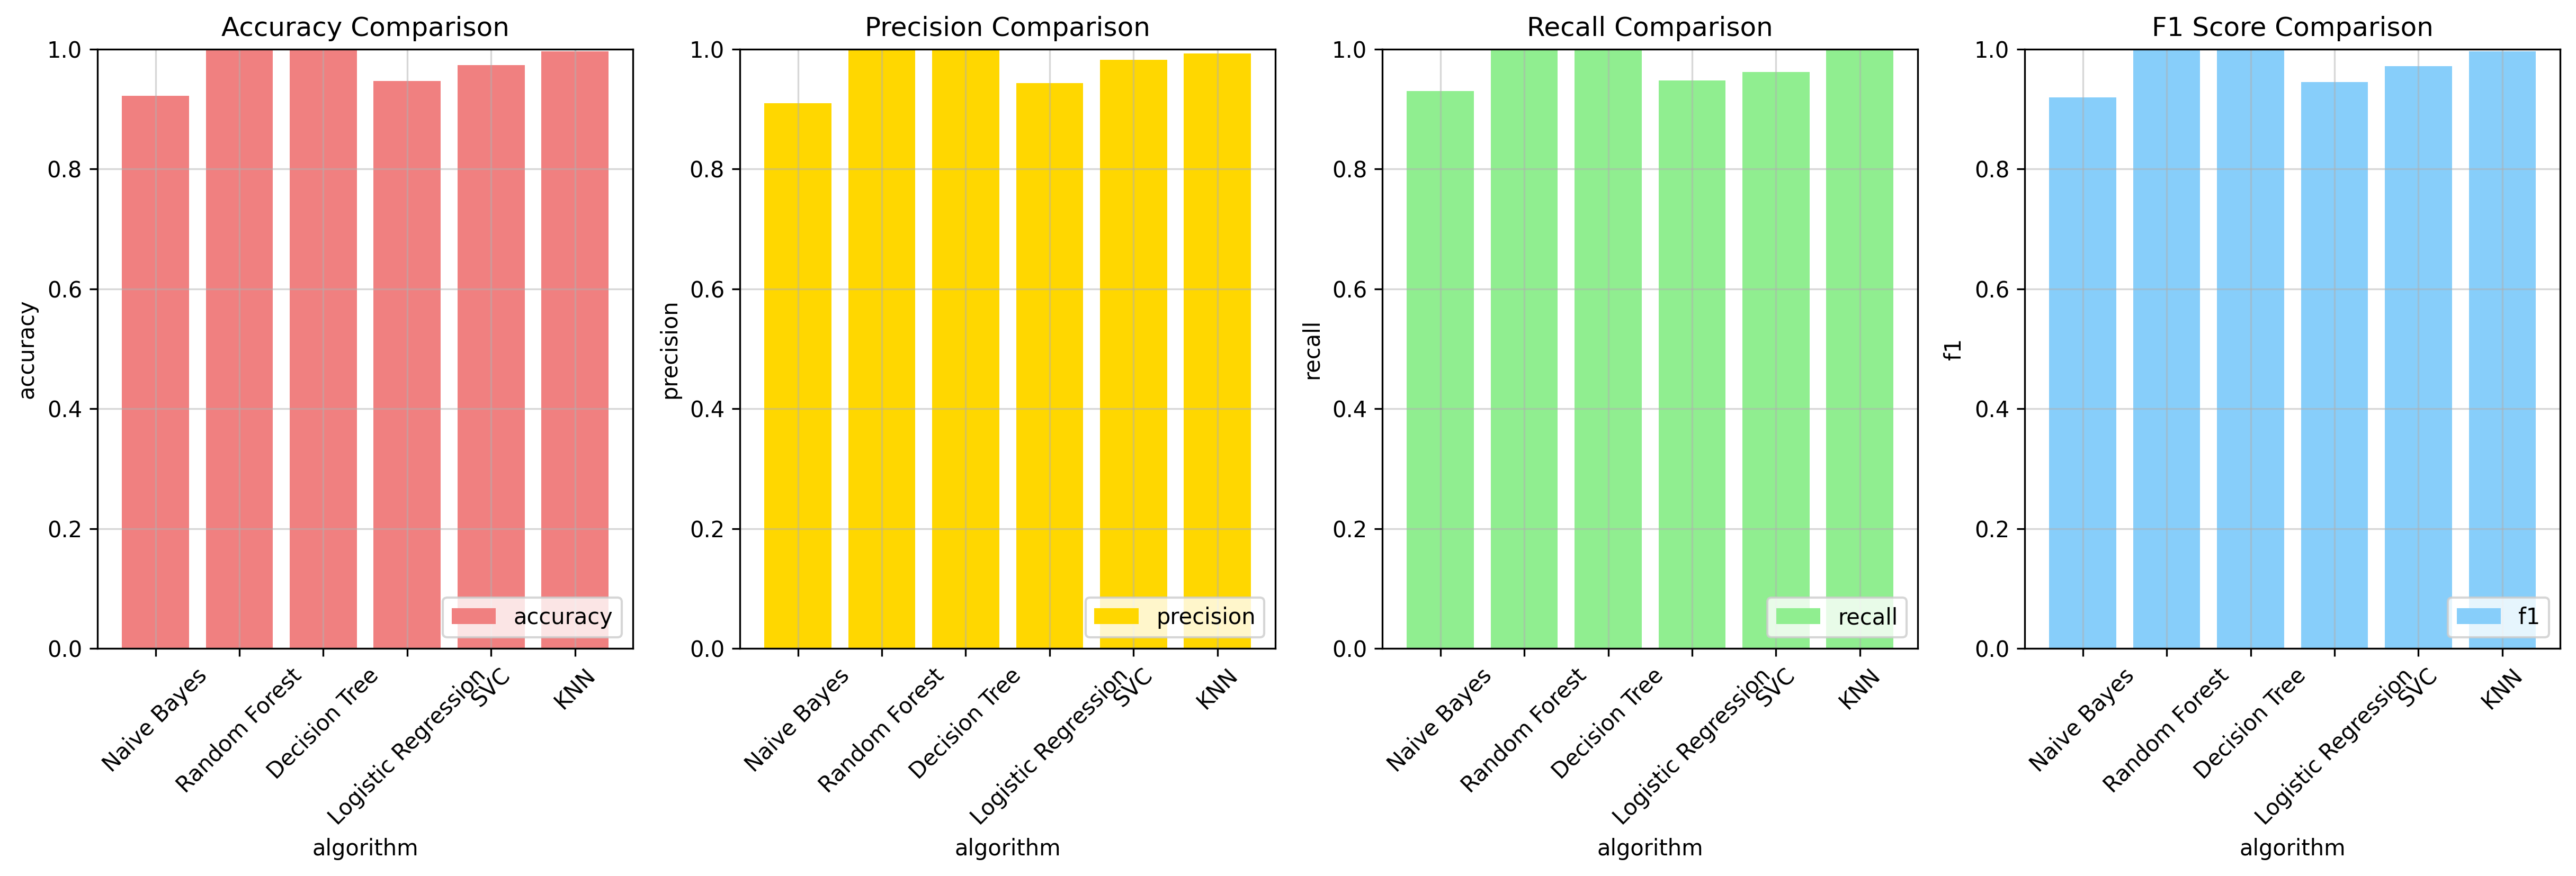

In [29]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,performance_metrics['accuracy'],color="lightcoral",alpha=1,label="accuracy") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,performance_metrics['precision'],color="gold",alpha=1,label="precision") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,performance_metrics['recall'],color="lightgreen",alpha=1,label="recall") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,performance_metrics['f1'],color="lightskyblue",alpha=1,label="f1") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)